In [1]:
!pip install timm
!pip install transformers

In [1]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

/tmp/ipykernel_34/491664227.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg
/kaggle/input/flickr8k/Images/2100735137_05c6079537.jpg
/kaggle/input/f

### Download dataset
You should have a kaggle account

In [3]:
!pip install kaggle --upgrade
os.environ['KAGGLE_USERNAME'] = "XXXXXX"
os.environ['KAGGLE_KEY'] = "XXXXXXXXXXXXXXXXXX"

!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip
dataset = "8k"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 954.1 kB/s eta 0:00:00 0:00:01m
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.4-py3-none-any.whl size=111926 sha256=95a9c17afd56d93834be2d9f1116a662cb20df8401094ea938d9f94a8f05f253
  Stored in directory: /root/.cache/pip/wheels/96/ea/6e/1ef402d5911f0536091cd6d9357682c64214efa960eab358b4
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.3
    Uninstalling kaggle-1.6.3:
      Successfully uninstalled kaggle-1.6.3
Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.10/site-packages/kaggle/cli.py", line 70, in main
    out = args.func(**command_args)
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 1493, in dataset_download_cli
    self.dataset_download_files(dataset,
  File "/opt/conda/lib/python3.10/site-packages/

## Some pre-preocessing

In [4]:
if dataset == "8k":
  df = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
  df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)]
  df.to_csv("/kaggle/working/captions.csv", index=False)
  df = pd.read_csv("/kaggle/working/captions.csv")
  image_path = "/kaggle/input/flickr8k/Images"
  captions_path = "/kaggle/working"
df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  id  
0  A child in a pink dress is climbing up a set o...   0  
1              A girl going into a wooden building .   0  
2   A little girl climbing into a wooden playhouse .   0  
3  A little girl climbing the stairs to her playh...   0  
4  A little girl in a pink dress going into a woo...   0

## Config

In [5]:
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    projection_dim = 128
    dropout = 0.1

## Utils

In [6]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

The dataset returns images and encoded captions as a dictionary.

In [7]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

## Image Encoder

We use the timm library, which comprises numerous pre-trained image models. It returns a tensor of size 2048 for each image.

In [8]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder (TO DO)

We utilize the DistilBertModel from HuggingFace Transformers, which generates a 756-size vector for each input token (word). Similar to the original Bert model, the CLS token embedding is use to represent the entire caption.

In [9]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state # This is an tensor of size (BATCH_SIZE, num_words, 756)
        ### TO DO: Just one Line ###
        ### You shoud return the embeding of the CLS token. CLS token index is self.target_token_idx
        cls_token_embedding = last_hidden_state[:, self.target_token_idx, :]

        return cls_token_embedding

## Projection Head (TO DO)

After encoding both images and texts into fixed-size vectors of 2048 and 768 dimensions respectively, we need to project them onto a new space. This new world space to have similar dimensions for both image and text vectors so that we can compare them. By doing so, we can segregate non-relevant image and text vectors and pull together those that match. To achieve this, we use a code that projects the 2048 and 768 dimensional vectors into a 128 dimensional space, where we can easily compare them.

Two instances of this class will be created to project image and text vectors.

In [10]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim, # the size of the input vector (2048 for images and 768 for texts)
        projection_dim=CFG.projection_dim, #  the the size of the output vector (Use 128)
        dropout=CFG.dropout
    ):
        ### TO DO: Whole Class ###
        ### It should be an MLP that project embeding_dim to projection_dim. Dont forget to use activation functions,layer norms and dropouts!
        super().__init__()

        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, projection_dim),
            nn.Dropout(dropout),
            nn.LayerNorm(projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim)  # Final projection to desired dimension
        )

    def forward(self, x):
        projected_x = self.projection(x)
        return projected_x

## CLIP: Putting it all to gather (TO DO)

This class encompasses all the logic behind CLIP. It projects images and text into a 128-dimensional space and computes the loss function.

In [11]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        ### TO DO ###
        ### Project both features into 128-dimentional space using above defined ProjectionHeads
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        ### TO DO ###
        ### Calculate loss and return it. You can set the temperture parameter to 1. (See figure 2 of the homework)

        # Calculate the similarity scores using dot product
        label = torch.matmul(text_embeddings , image_embeddings.T)/ self.temperature
        loss_i = torch.matmul(image_embeddings , image_embeddings.T)
        loss_j = torch.matmul(text_embeddings , text_embeddings.T)
        targets = F.softmax((loss_i + loss_j) / 2* self.temperature , dim=-1)
        loss =  (cross_entropy(label.T, targets.T, reduction='none') + cross_entropy(label.T, targets.T, reduction='none')) / 2.0


        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

## Train

Here are some funtions to help us load train and valid dataloaders, our model and then train and evaluate our model on those. There's not much going on here; just simple training loop and utility functions

In [12]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

Here's a handy function to train our model. There's not much happening here; just loading the batches, feeding them to the model and stepping the optimizer and lr_scheduler.

In [13]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "/kaggle/working/best.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)

Running the next cell start training the model. Put the kernel on GPU mode. Every epoch should take about 8 minutes on GPU if you are using 8k version (even one epoch is enough!).

In [14]:
main()

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch: 1


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

In [15]:
!zip -r file.zip /kaggle/working/best.pt

from IPython.display import FileLink
FileLink(r'file.zip')

  adding: kaggle/working/best.pt (deflated 8%)


/kaggle/working/file.zip

In [28]:
FileLink(r'file.zip')

/kaggle/working/file.zip

## Inference

### Getting Image Embeddings (TO DO)

In this function, we are loading the model that we saved after training, feeding it images in validation set and returning the image_embeddings with shape (valid_set_size, 256) and the model itself.

In [16]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    valid_image_embeddings = []
    ### TO DO ###
    ### Loop trought validation dataloader and get 128-dim embeding of all images
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [17]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "/kaggle/working/best.pt")

  0%|          | 0/253 [00:00<?, ?it/s]

### Finding Matches (TO DO)

This function does the final task that we wished our model would be capable of: it gets the model, image_embeddings, and a text query. It will display the most relevant images from the validation set! Isn't it amazing? Let's see how it performs after all!

In [32]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
        ### TO DO ###
        ### Find and plot n nearest image to given query
        # Calculate similarity scores between text embedding and all image embeddings
        similarity_scores = torch.matmul(image_embeddings,text_embeddings.T)

        # Find the indices of the n most similar images
        top_n_indices = torch.topk(similarity_scores.T, n*5)[1].cpu().numpy()
        images = [image_filenames[idx] for idx in top_n_indices[0]]
        images = list(set(images))

        # Plot the n most relevant images
        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
        for i, ax in enumerate(axes.flat):
            if i < n:
                image_index = top_n_indices[0][i]
                image_filename = image_filenames[image_index]
                image = plt.imread(f"{CFG.image_path}/{images[i]}")
                ax.imshow(image)
                ax.set_title(image_filename)
                ax.axis("off")
        plt.tight_layout()
        plt.show()

This is how we use this function. Aaaannnndddd the results:
(The results in the blog post and the one at the beginning of the notebook were achieved with training on the 30k version)

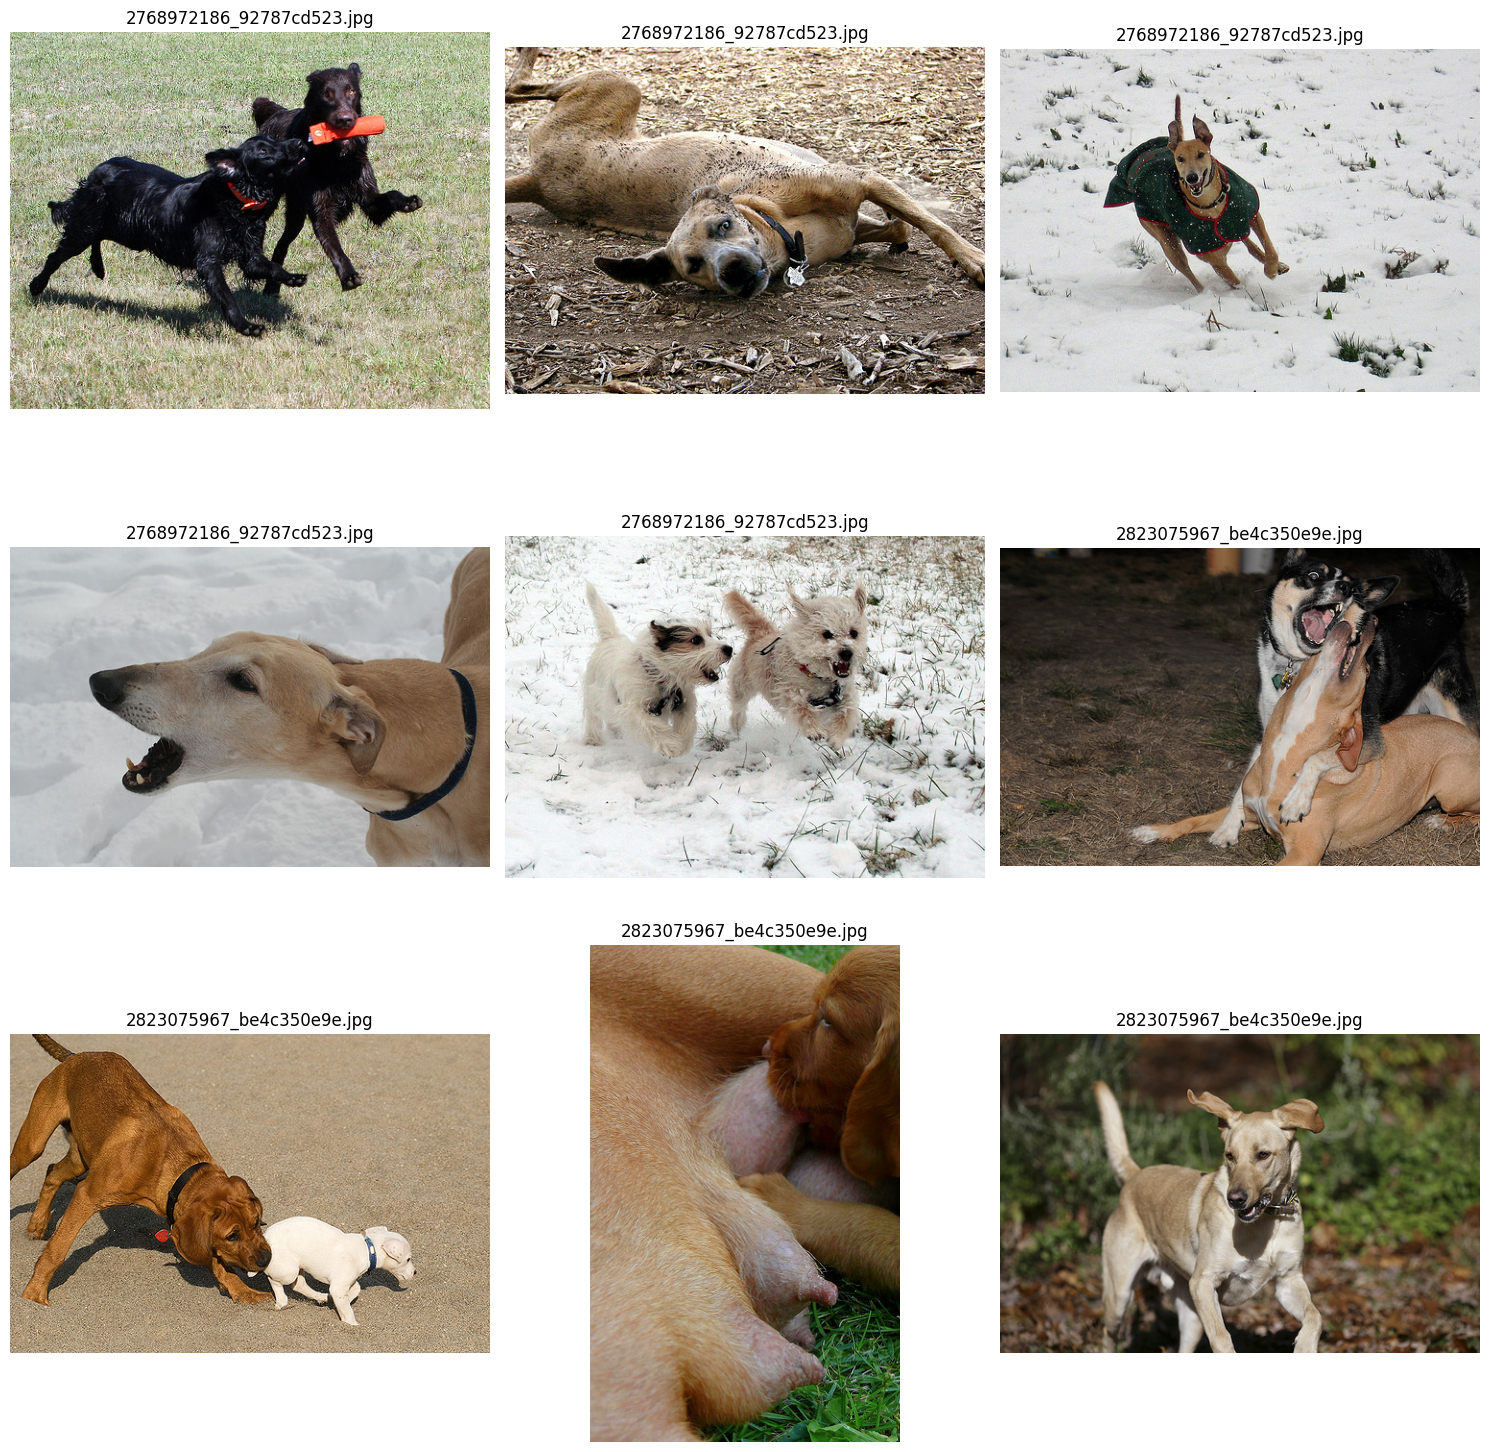

In [33]:
find_matches(model,
             image_embeddings,
             query="This is a dog",
             image_filenames=valid_df['image'].values,
             n=9)